# Assignment 5: Scene Recognition with Bag of Words

In [44]:
import numpy as np
import os
import glob
from sklearn.cluster import KMeans
from tqdm import tqdm
from matplotlib import pyplot as plt

## Question 4: bags of SIFT descriptors
### Question 4a: clustering SIFT descriptors with K-means 

In [40]:
def load(ds_path):
    """ Load from the training/testing dataset.

    Parameters
    ----------
    ds_path: path to the training/testing dataset.
             e.g., sift/train or sift/test 
    
    Returns
    -------
    image_paths: a (n_sample, 1) array that contains the paths to the descriptors. 
    labels: class labels corresponding to each image
    """
    # Grab a list of paths that matches the pathname
    files = glob.glob(os.path.join(ds_path, "*", "*.txt"))
    n_files = len(files)
    image_paths = np.asarray(files)
 
    # Get class labels
    classes = glob.glob(os.path.join(ds_path, "*"))
    labels = np.zeros(n_files)

    for i, path in enumerate(image_paths):
        folder, fn = os.path.split(path)
        labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]

    # Randomize the order
    idx = np.random.choice(n_files, size=n_files, replace=False)
    image_paths = image_paths[idx]
    labels = labels[idx]
    return image_paths, labels

def build_vocabulary(image_paths, vocab_size):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    vocab_size: the number of clusters desired.
    
    Returns
    -------
    kmeans: the fitted k-means clustering model.
    """
    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(10000 / n_image))

    # Initialize an array of features, which will store the sampled descriptors
    # keypoints = np.zeros((n_image * n_each, 2))
    descriptors = np.zeros((n_image * n_each, 128))

    for i, path in tqdm(enumerate(image_paths)):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        sift_keypoints = features[:, :2]
        sift_descriptors = features[:, 2:]
        
        # Randomly sample n_each descriptors from sift_descriptor and store them into descriptors
        n,d = sift_descriptors.shape
        indices = np.random.choice(n, n_each)
        descriptors[i:i+n_each,:] = sift_descriptors[indices]

    # Perfom k-means clustering to cluster sampled sift descriptors into vocab_size regions.
    print("Fitting K-means clustering")
    kmeans = KMeans(n_clusters=50, random_state=0).fit(descriptors)
    
    return kmeans

In [41]:
print('Getting paths and labels for all train and test data')
train_image_paths, train_labels = load("sift/train")
test_image_paths, test_labels = load("sift/test")

print('Extracting SIFT features')
kmeans = build_vocabulary(train_image_paths, vocab_size=200)

0it [00:00, ?it/s]

Getting paths and labels for all train and test data
Extracting SIFT features


1500it [01:40, 14.90it/s]


Fitting K-means clustering
[[-1.46549439e-13 -5.06705788e-13  4.24993374e-13 ...  8.99280650e-14
   3.44613227e-13  2.89990254e-13]
 [ 3.08750000e+01  1.27500000e+01  8.46875000e+00 ...  4.06250000e+00
   7.53125000e+00  1.77187500e+01]
 [ 2.18064516e+01  1.49032258e+01  1.22903226e+01 ...  2.12903226e+00
   1.35483871e+00  7.61290323e+00]
 ...
 [ 3.14827586e+01  1.48620690e+01  1.09310345e+01 ...  4.17241379e+00
   9.13793103e+00  1.76551724e+01]
 [ 1.30163934e+01  7.77049180e+00  1.32622951e+01 ...  4.49180328e+00
   4.06557377e+00  8.13114754e+00]
 [ 1.24615385e+01  7.07692308e+00  4.16923077e+01 ...  2.07692308e+00
   1.03846154e+01  2.25384615e+01]]


### Question 4b: representing images as bags of SIFT feature histograms

In [88]:
def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]

    image_feats = np.zeros((n_image, vocab_size))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)

        # Assign each feature to the closest cluster center
        # Again, each feature consists of the (x, y) location and the 128-dimensional sift descriptor
        # You can access the sift descriptors part by features[:, 2:]
        sift_descriptors = features[:, 2:]
        predictions = kmeans.predict(sift_descriptors)

        # Build a histogram normalized by the number of descriptors
        hist, bins = np.histogram(predictions, bins=np.arange(vocab_size+1), density=True)
        image_feats[i,:] = hist
        
    return image_feats

In [89]:
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)

### Question 4c: average histogram for each scene category

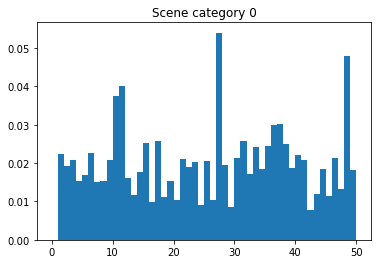

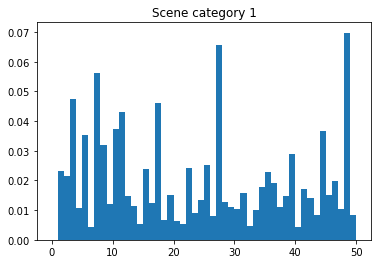

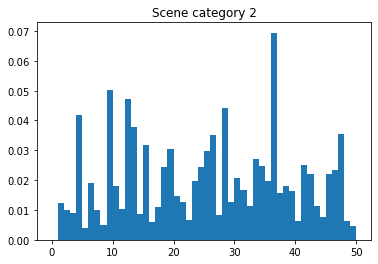

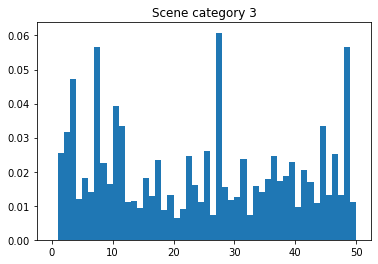

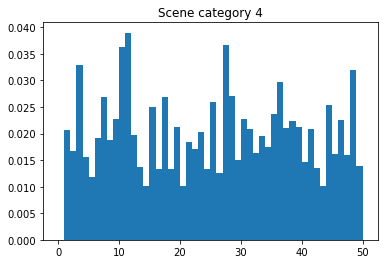

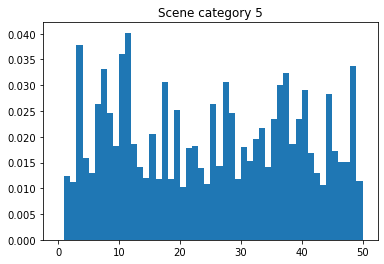

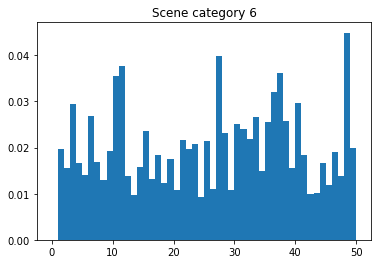

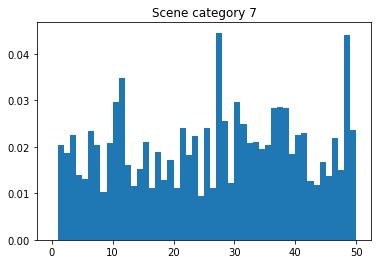

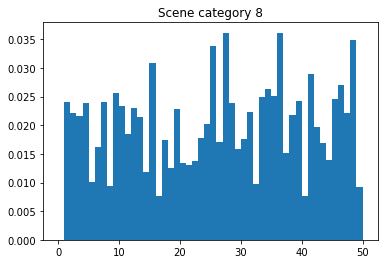

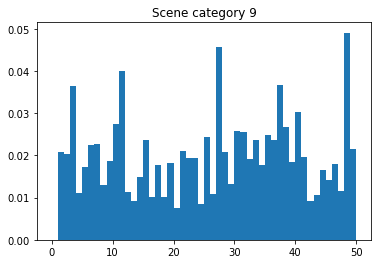

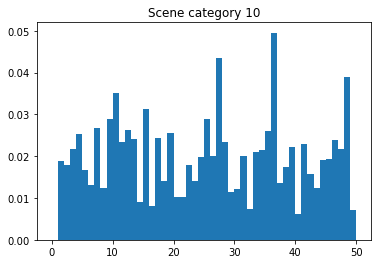

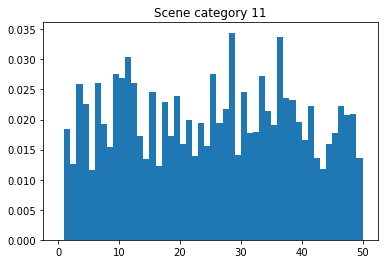

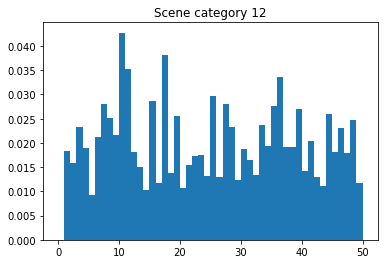

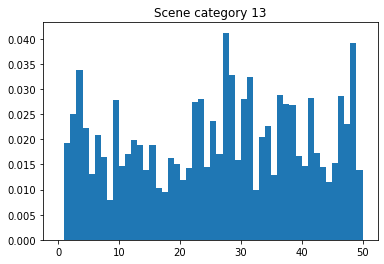

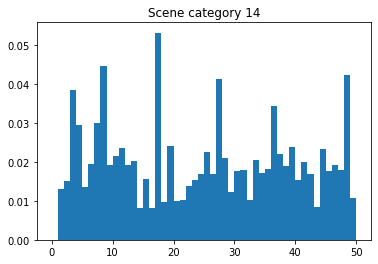

In [93]:
vocab_size = kmeans.cluster_centers_.shape[0]
category_feats = np.zeros((15, vocab_size))
bins = np.arange(vocab_size+1)

for row, label in zip(train_image_feats, train_labels):
    category_feats[int(label),:] = category_feats[int(label),:] + row

for i, category in enumerate(category_feats):
    category_feats[i] = category / list(train_labels).count(i)
    plt.hist(bins[:-1], bins, weights=category_feats[i])
    plt.title("Scene category {}".format(i))
    plt.show()
    
# print(category_feats)

## Question 5: scene recongition with KNN
This function will predict the category for every test image by finding the training image with most similar features. Instead of 1 nearest neighbor, you can vote based on k nearest neighbors which will increase performance (although you need to pick a reasonable value for k).

In [6]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):
    """
    Parameters
    ----------
    train_image_feats: is an N x d matrix, where d is the dimensionality of the feature representation.
    train_labels: is an N x l cell array, where each entry is a string
                  indicating the ground truth one-hot vector for each training image.
    test_image_feats: is an M x d matrix, where d is the dimensionality of the
                      feature representation. You can assume M = N unless you've modified the starter code.

    Returns
    -------
    is an M x l cell array, where each row is a one-hot vector
    indicating the predicted category for each test image.
    """
    return predicted_labels

In [ ]:
print('Using nearest neighbor classifier to predict test set categories')
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

## Question 6: scene recognition with 1-vs-all linear SVMs
This function will train a linear SVM for every category (i.e. one vs all) and then use the learned linear classifiers to predict the category of very test image. Every test feature will be evaluated with all 15 SVMs and the most confident SVM will "win". Confidence, or distance from the margin, is W*X + B where '*' is the inner product or dot product and W and B are the learned hyperplane parameters. 

In [ ]:
def svm_classify(train_image_feats, train_labels, test_image_feats):
    """
    Parameters
    ----------
    train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
    train_labels: is an N x l cell array, where each entry is a string
                  indicating the ground truth one-hot vector for each training image.
    test_image_feats: is an M x d matrix, where d is the dimensionality of the
                      feature representation. You can assume M = N unless you've modified the starter code.

    Returns
    -------
    is an M x l cell array, where each row is a one-hot vector
    indicating the predicted category for each test image.
    """
    return predicted_labels

In [ ]:
print('Using support vector machine to predict test set categories')
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)